In [1]:
%reset -f

Imports & Config

In [2]:
import pandas as pd
import os
from datetime import datetime

RAW_FOLDER = "raw"
MASTER_FOLDER = "masters"
OUTPUT_FOLDER = "output"
PROCESSED_FOLDER = "processed_files"

all_files = [f for f in os.listdir(RAW_FOLDER) if f.endswith(".xlsx")]

if not all_files:
    print("⚠ No Excel files found in raw folder.")
else:
    dataframes = []
    for file in all_files:
        path = os.path.join(RAW_FOLDER, file)
        df = pd.read_excel(path)
        dataframes.append(df)

    sales_df = pd.concat(dataframes, ignore_index=True)
    print("sales_df created successfully")


sales_df created successfully


Load Raw Files

In [3]:
all_files = [f for f in os.listdir(RAW_FOLDER) if f.endswith(".xlsx")]

if not all_files:
    print("⚠ No new raw files found.")
else:
    print("Files detected:", all_files)

dataframes = []

for file in all_files:
    path = os.path.join(RAW_FOLDER, file)
    df = pd.read_excel(path)
    dataframes.append(df)

if dataframes:
    sales_df = pd.concat(dataframes, ignore_index=True)
    print("Raw data loaded successfully.")
    sales_df.head()


Raw data loaded successfully.


Load Customer Master

In [4]:
master_path = os.path.join(MASTER_FOLDER, "customer_master.xlsx")
master_df = pd.read_excel(master_path)


**STANDARDIZE FUNCTION**

In [5]:
def standardize(df):
    """
    Standardizes column names and text values:
    - Strips spaces
    - Converts column names to uppercase
    - Converts all string values to uppercase
    """

    # Standardize column names
    df.columns = df.columns.str.strip().str.upper()

    # Standardize string/object columns
    for col in df.select_dtypes(include=["object", "string"]).columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

    return df


In [6]:
sales_df = standardize(sales_df)


**EXCLUDE MATERIAL GROUPS**

In [7]:
EXCLUDE_KEYWORDS = [
    "SERVICE",
    "AIR VENT",
    "PACKING",
    "RAW",
    "BRASS",
    "PANEL",
    "SALES ACCOUNT",
    "MASTER BATCH",
    "SEMI",
    "PPCP",
    "FIXED",
    "PROTECTION",
    "HIPS",
    "ABS",
    "INDIRECT",
    "NYLOAN",
    "PP BLACK",

    "NASER MILES PARIS",
    "DOCUMENT HOLDER",
    "SWISS MILITARY MODLE MAZE",
    "SELF ADHESIVE TIE MOUNT",
    "SCREW TYPE TIE MOUNT"
]


before_count = len(sales_df)

for keyword in EXCLUDE_KEYWORDS:
    sales_df = sales_df[
        ~sales_df["MATERIALGROUP"].str.contains(keyword, case=False, na=False)
    ]

after_count = len(sales_df)

print("Rows removed:", before_count - after_count)
print("Remaining rows:", after_count)


Rows removed: 1654
Remaining rows: 25124


**COMBINE ALL CONDUIT GLAND VARIATIONS**

In [8]:
# ---- 1️⃣ Combine all conduit gland variations ----

sales_df.loc[
    sales_df["MATERIALGROUP"].str.contains(
        "CONDUIT.*GLAND", case=False, na=False
    ),
    "MATERIALGROUP"
] = "POLYAMIDE CONDUIT GLAND"


# ---- 2️⃣ Fix Reverse Forward spelling variations ----

sales_df.loc[
    sales_df["MATERIALGROUP"].str.contains(
        "REVER", case=False, na=False
    ),
    "MATERIALGROUP"
] = "REVERSE FORWARD"

sales_df.loc[
    sales_df["MATERIALGROUP"].str.contains(
        "REVERSE FORWORD", case=False, na=False
    ),
    "MATERIALGROUP"
] = "REVERSE FORWARD"


In [9]:
sales_df["MATERIALGROUP"].value_counts()


MATERIALGROUP
AIR FILTER                             6542
SELF LOCKING PA 66 CABLE TIE           3919
JUNCTION BOXES                         3917
POLYMIDE FLEXIBLE CONDUIT & SLITTED    3403
POLYAMIDE CONDUIT GLAND                1724
SELF ADHESIVE GASKET TAPE              1375
PUSH BUTTON STATION                     885
OTHER ACCESSORIES                       831
TOGGLE SWITCH                           454
METAL FAN FINGER GUARD                  453
POLYMIDE FLEXIBLE CONDUIT CLAMP         425
FAN FINGER GUARD                        350
DISTRIBUTION BOXES                      319
REVERSE FORWARD                         300
SS CABLE TIES                           226
P P FLEXIBLE CONDUIT                      1
Name: count, dtype: int64

Add Financial Year

In [10]:
FY_START_MONTH = 4

sales_df["DATE"] = pd.to_datetime(sales_df["DATE"])

def calculate_fy(date):
    if date.month >= FY_START_MONTH:
        return f"FY{date.year % 100}-{(date.year + 1) % 100}"
    else:
        return f"FY{(date.year - 1) % 100}-{date.year % 100}"

sales_df["FINANCIAL_YEAR"] = sales_df["DATE"].apply(calculate_fy)

sales_df.head()


,NO.,DATE,CUSTOMER NAME,ITEMNAME,MATERIALGROUP,COLOUR,QTY,RATE,AMOUNT,SGST,CGST,IGST,TAX,TOTALAMOUNT,FINANCIAL_YEAR
0,KNE/0001/24-25,2024-04-02,APS KAHAN CORPORATION,(ETAV-01VP) 130MM X 130MM VP RAL-7035,AIR FILTER,RAL-7035,30.0,440.0,4950.00,0.0,0.0,891.00,891.00,29847,FY24-25
1,KNE/0001/24-25,2024-04-02,APS KAHAN CORPORATION,(ETAV-03) 184MM X 184MM RAL-7035,AIR FILTER,RAL-7035,150.0,145.0,8156.25,0.0,0.0,1468.13,1468.13,0,FY24-25
2,KNE/0001/24-25,2024-04-02,APS KAHAN CORPORATION,(ETAV-02) 147MM X 147MM RAL-7035,AIR FILTER,RAL-7035,200.0,75.0,5625.00,0.0,0.0,1012.50,1012.50,0,FY24-25
3,KNE/0001/24-25,2024-04-02,APS KAHAN CORPORATION,(ETAV-04) 203MM X 203MM RAL-7035,AIR FILTER,RAL 7035,100.0,175.0,6562.50,0.0,0.0,1181.25,1181.25,0,FY24-25
4,KNE/0002/24-25,2024-04-02,APEX ELECTROCARE LLP,(ETAV-01VP) 130MM X 130MM VP RAL-7035,AIR FILTER,RAL-7035,150.0,440.0,24750.00,0.0,0.0,4455.00,4455.00,29205,FY24-25


Merge Customer Master

In [11]:
# Standardize both
sales_df = standardize(sales_df)
master_df = standardize(master_df)

# Merge
sales_df = pd.merge(
    sales_df,
    master_df,
    on="CUSTOMER NAME",
    how="left"
)

print("Merge completed successfully.")


Merge completed successfully.


Incremental Loading Logic

In [12]:
output_path = os.path.join(OUTPUT_FOLDER, "sales_master.xlsx")

if os.path.exists(output_path):

    existing_df = pd.read_excel(output_path)
    existing_df = standardize(existing_df)

    existing_invoices = set(existing_df["NO."])
    new_records = sales_df[~sales_df["NO."].isin(existing_invoices)]

    print("New records detected:", len(new_records))

    if len(new_records) > 0:
        updated_df = pd.concat([existing_df, new_records], ignore_index=True)
        updated_df.to_excel(output_path, index=False)
        print("Incremental update completed.")
    else:
        print("No new invoices to append.")
        updated_df = existing_df  # 🔥 IMPORTANT FIX

else:
    sales_df.to_excel(output_path, index=False)
    updated_df = sales_df  # 🔥 IMPORTANT FIX
    new_records = sales_df
    print("Master file created.")


New records detected: 0
No new invoices to append.


Audit Log

In [13]:
audit_path = os.path.join(OUTPUT_FOLDER, "audit_log.xlsx")

new_count = len(new_records)
total_count = len(updated_df)

log_entry = pd.DataFrame([{
    "RUN_TIMESTAMP": datetime.now(),
    "NEW_RECORDS_ADDED": new_count,
    "TOTAL_RECORDS_AFTER_RUN": total_count
}])

if os.path.exists(audit_path):
    existing_log = pd.read_excel(audit_path)
    updated_log = pd.concat([existing_log, log_entry], ignore_index=True)
else:
    updated_log = log_entry

updated_log.to_excel(audit_path, index=False)

print("Audit log updated.")


Audit log updated.


Monthly Summary

In [14]:
updated_df["MONTH"] = updated_df["DATE"].dt.to_period("M")

summary = updated_df.groupby(["FINANCIAL_YEAR", "MONTH"]).agg(
    TOTAL_SALES=("TOTALAMOUNT", "sum"),
    TOTAL_QTY=("QTY", "sum")
).reset_index()

summary["MONTH"] = summary["MONTH"].astype(str)

summary.to_excel(os.path.join(OUTPUT_FOLDER, "monthly_summary.xlsx"), index=False)

summary.head()


,FINANCIAL_YEAR,MONTH,TOTAL_SALES,TOTAL_QTY
0,FY24-25,2024-04,8453676,186933
1,FY24-25,2024-05,12530239,417247
2,FY24-25,2024-06,14221891,430675
3,FY24-25,2024-07,14170002,508594
4,FY24-25,2024-08,13121594,417381


Move Processed Files

In [15]:
for file in all_files:
    old_path = os.path.join(RAW_FOLDER, file)
    new_path = os.path.join(PROCESSED_FOLDER, file)
    os.rename(old_path, new_path)

print("Processed files moved.")


State-wise Sales Summary


In [16]:
state_summary = updated_df.groupby("STATE").agg(
    TOTAL_SALES=("TOTALAMOUNT", "sum"),
    TOTAL_QTY=("QTY", "sum"),
    UNIQUE_CUSTOMERS=("CUSTOMER NAME", "nunique")
).reset_index()

state_summary = state_summary.sort_values("TOTAL_SALES", ascending=False)

state_summary.head(10)


,STATE,TOTAL_SALES,TOTAL_QTY,UNIQUE_CUSTOMERS
12,MAHARASHTRA,163952047,7274343,101
6,GUJARAT,55719449,1627676,42
9,KARNATAKA,53306539,1912374,22
15,TAMIL NADU,17137906,642550,24
18,WEST BENGAL,6883417,163826,5
16,TELANGANA,6880427,329420,15
7,HARYANA,5382991,295586,8
11,MADHYA PRADESH,5147529,119120,8
5,DELHI,3650578,132414,9
13,PUNJAB,940303,31183,5


Top 10 Customers Ranking

In [17]:
customer_summary = updated_df.groupby("CUSTOMER NAME").agg(
    TOTAL_SALES=("TOTALAMOUNT", "sum"),
    TOTAL_QTY=("QTY", "sum")
).reset_index()

customer_summary = customer_summary.sort_values("TOTAL_SALES", ascending=False)

top_customers = customer_summary.head(10)

top_customers


,CUSTOMER NAME,TOTAL_SALES,TOTAL_QTY
246,SHREE MAHAVIR ELECTRICALS,31669650,1278461
179,PAWAR ELECTRONICS,21933739,1050786
265,SULOCHANA TECHNOLOGICAL PVT LTD,15735939,458324
60,DINESH ENTERPRISES,13408445,645968
227,SANJAY ELECTRICALS,12586060,405939
19,APEX ELECTROCARE LLP,10572780,233865
263,SULOCHANA ENTERPRISES(PEENYA),9106019,336214
20,APS KAHAN CORPORATION,8542929,180983
185,POWER TRADE LINK,8225651,279276
131,MADHUVAN ELECTRICALS,7847973,269616


Monthly Sales Trend Chart

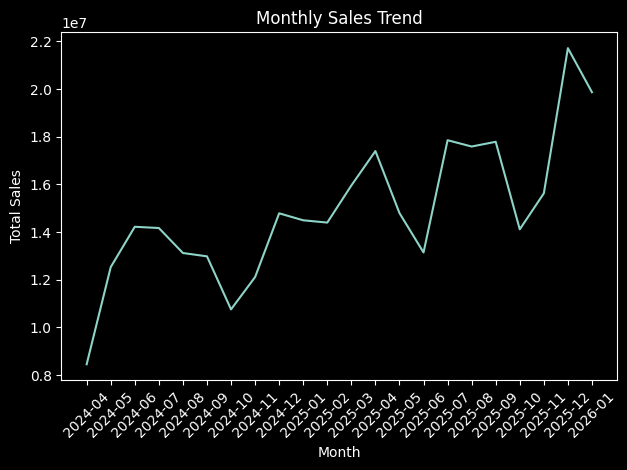

In [18]:
import matplotlib.pyplot as plt

monthly_trend = updated_df.groupby("MONTH").agg(
    TOTAL_SALES=("TOTALAMOUNT", "sum")
).reset_index()

monthly_trend["MONTH"] = monthly_trend["MONTH"].astype(str)

plt.figure()
plt.plot(monthly_trend["MONTH"], monthly_trend["TOTAL_SALES"])
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


Customer Contribution %

In [19]:
total_sales = updated_df["TOTALAMOUNT"].sum()

customer_summary["CONTRIBUTION_%"] = (
    customer_summary["TOTAL_SALES"] / total_sales
) * 100

customer_summary.head(10)


,CUSTOMER NAME,TOTAL_SALES,TOTAL_QTY,CONTRIBUTION_%
246,SHREE MAHAVIR ELECTRICALS,31669650,1278461,9.659022
179,PAWAR ELECTRONICS,21933739,1050786,6.689637
265,SULOCHANA TECHNOLOGICAL PVT LTD,15735939,458324,4.799351
60,DINESH ENTERPRISES,13408445,645968,4.089482
227,SANJAY ELECTRICALS,12586060,405939,3.838660
19,APEX ELECTROCARE LLP,10572780,233865,3.224624
263,SULOCHANA ENTERPRISES(PEENYA),9106019,336214,2.777272
20,APS KAHAN CORPORATION,8542929,180983,2.605534
185,POWER TRADE LINK,8225651,279276,2.508766
131,MADHUVAN ELECTRICALS,7847973,269616,2.393577


In [20]:
print(sales_df.columns)


Index(['NO.', 'DATE', 'CUSTOMER NAME', 'ITEMNAME', 'MATERIALGROUP', 'COLOUR',
       'QTY', 'RATE', 'AMOUNT', 'SGST', 'CGST', 'IGST', 'TAX', 'TOTALAMOUNT',
       'FINANCIAL_YEAR', 'CITY', 'STATE'],
      dtype='str')


FINAL SHEET

In [21]:
import os
os.makedirs("output", exist_ok=True)

sales_df.to_excel("output/sales_master.xlsx", index=False)

print("Final master saved successfully.")


Final master saved successfully.


In [22]:
print("Final dataset rows:", len(sales_df))

import os
print("Output folder files:", os.listdir("output"))


Final dataset rows: 25124
Output folder files: ['audit_log.xlsx', 'monthly_summary.xlsx', 'sales_master.xlsx']


# Make SQL-safe column names

In [23]:

sales_df.columns = (
    sales_df.columns
    .str.strip()
    .str.replace(".", "", regex=False)
    .str.replace(" ", "_")
    .str.upper()
)

# Rename invoice column clearly
sales_df = sales_df.rename(columns={"NO": "INVOICE_NO"})


**# SQL LITE INTEGRATION**

In [ ]:
import sqlite3

conn = sqlite3.connect("sales_database.db")

sales_df.to_sql(
    "sales_master",
    conn,
    if_exists="replace",
    index=False
)

conn.close()

print("Fresh database created successfully.")


In [25]:
conn = sqlite3.connect("sales_database.db")

existing_df = pd.read_sql(
    "SELECT INVOICE_NO FROM sales_master",
    conn
)

existing_invoices = set(existing_df["INVOICE_NO"])

new_records = sales_df[
    ~sales_df["INVOICE_NO"].isin(existing_invoices)
]

if len(new_records) > 0:
    new_records.to_sql(
        "sales_master",
        conn,
        if_exists="append",
        index=False
    )
    print(f"{len(new_records)} new records inserted.")
else:
    print("No new records.")

conn.close()


No new records.


In [27]:
conn = sqlite3.connect("sales_database.db")
df_export = pd.read_sql("SELECT * FROM sales_master", conn)
df_export.to_csv("output/sales_master.csv", index=False)
conn.close()


In [2]:
st.write(df.columns)


2026-02-13 17:40:05.125 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
